In [63]:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly
#import plotly.express.colors as color
%matplotlib inline

## 1. Data

In [124]:
bicycle = pd.read_csv('_data/train.csv')
t_bicycle = pd.read_csv('_data/test.csv')
bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


In [65]:
t_bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability
0,2021-04-01,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333
1,2021-04-02,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500
2,2021-04-03,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847
3,2021-04-04,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671
4,2021-04-05,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459


In [66]:
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []
    
    for date in dataframe.date_time :
        year_point, month_point, day_point = date.split('-')
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
        
    return year, month, day

for D in [bicycle, t_bicycle]:
    year, month, day = seperate_datetime(D)
    D['year'] = year
    D['month'] = month
    D['day'] = day
    D['weekday'] = pd.to_datetime(D['date_time']).dt.weekday
    D.drop('date_time', axis=1, inplace=True)
    D['weekend'] = D['weekday'] >= 5
    D['time'] = D['year']*10 + D['month']
    
bicycle.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day,weekday,weekend,time
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,6,True,20184
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,0,False,20184
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,1,False,20184
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,2,False,20184
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,3,False,20184


## 2.EDA

### 시계열 분해

<AxesSubplot:ylabel='number_of_rentals'>

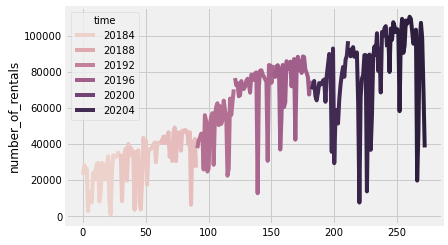

In [67]:
sns.lineplot(data=bicycle, 
             x=bicycle.index,
             y='number_of_rentals',
             hue='time',
             markers=True)

시간에 대한 가중치가 너무 높지 않을까?

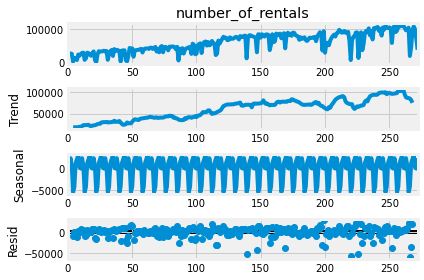

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(bicycle['number_of_rentals'], model='additive', period=9)

ax = res.plot()

<AxesSubplot:ylabel='number_of_rentals'>

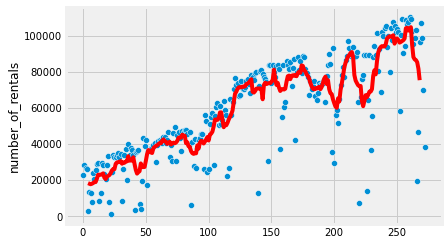

In [69]:
sns.scatterplot(data = bicycle['number_of_rentals'])
sns.lineplot(data = res.trend, color = 'red')

<AxesSubplot:>

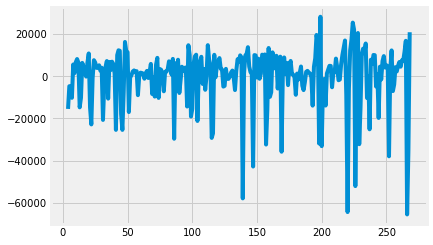

In [70]:
sns.lineplot(data = (bicycle['number_of_rentals'] - res.trend))

In [71]:
nor = bicycle['number_of_rentals']

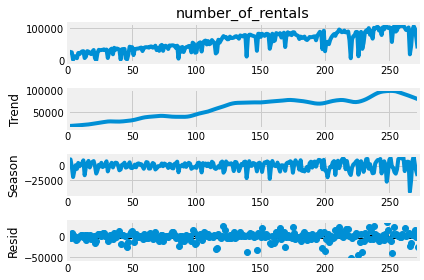

In [72]:
from statsmodels.tsa.seasonal import STL
stl = STL(nor, period=18)
res = stl.fit()
fig = res.plot()

<AxesSubplot:ylabel='number_of_rentals'>

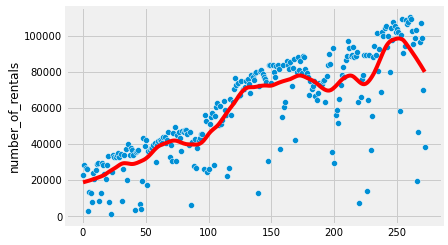

In [73]:
sns.scatterplot(data = nor)
sns.lineplot(data = res.trend, color = 'red')

In [74]:
y_no_time = nor - res.trend

<AxesSubplot:>

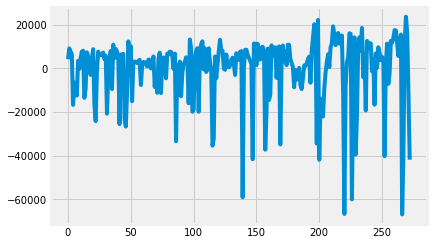

In [75]:
sns.lineplot(data = y_no_time)

### 데이터 정리

시간 관련 데이터 제거

In [76]:
bicycle['y_no_time'] = y_no_time
bicycle_no_time = bicycle.drop(['year', 'month', 'day', 'time', 'number_of_rentals'], axis=1)
t_bicycle_no_time = t_bicycle.drop(['year', 'month', 'day', 'time'], axis=1)

### 데이터 분포

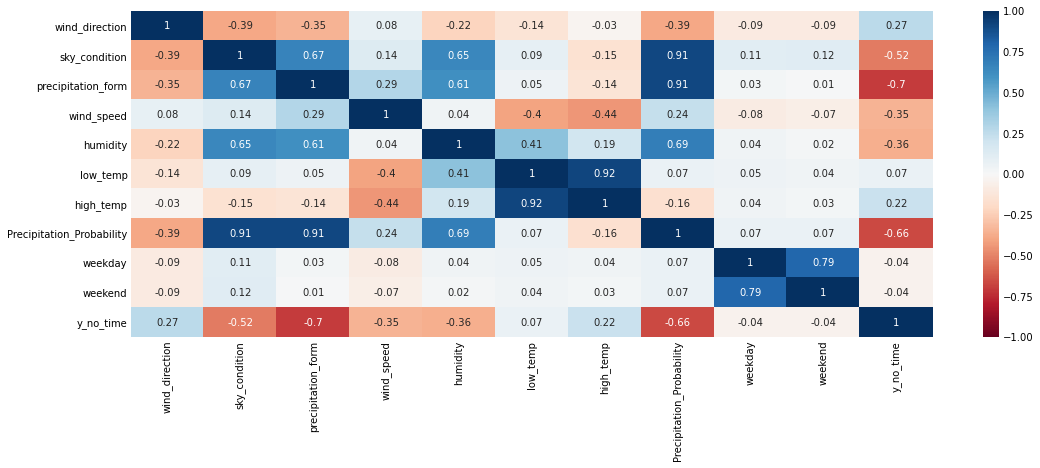

In [77]:
corr = np.round(bicycle_no_time.corr(),2)
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(16,6))
hm = sns.heatmap(corr,
                 #mask=mask,
                 vmin=-1, 
                 vmax=1, 
                 annot=True,
                 cmap='RdBu'
    )

- wind_direction: 풍향 (degree)
- sky_condition : 맑음(1), 구름많음(3), 흐림(4)
- precipitation_form : 강수 형태 / 없음(0), 비(1), 진눈깨비(2), 눈(3), 소나기(4)
- wind_speed : 풍속 (m/s)
- humidity : 습도 (%)
- low_temp : 최저 기온 ( `C)
- high_temp : 최고 기온 ( `C)
- Precipitation_Probability : 강수 확률 (%)
- number_of_rentals : 따릉이 대여량

In [78]:
# masked_corr = corr.mask(np.tril(np.ones(corr.shape)).astype(bool))
# corr_rank = np.abs(masked_corr[masked_corr < 1]).unstack().sort_values(ascending = False).to_frame()
# corr_rank.dropna(inplace=True)

In [79]:
corr_dic = {}
for col in corr.columns:
    corr_dic[col] = np.abs(corr).loc[:,col].sort_values(ascending=False)

In [80]:
def corr_compare(*array):
    col = corr.columns
    print(col)
    for n in array :
        print(corr_dic.get(col[n]))

In [81]:
corr_compare(7)

Index(['wind_direction', 'sky_condition', 'precipitation_form', 'wind_speed',
       'humidity', 'low_temp', 'high_temp', 'Precipitation_Probability',
       'weekday', 'weekend', 'y_no_time'],
      dtype='object')
Precipitation_Probability    1.00
sky_condition                0.91
precipitation_form           0.91
humidity                     0.69
y_no_time                    0.66
wind_direction               0.39
wind_speed                   0.24
high_temp                    0.16
low_temp                     0.07
weekday                      0.07
weekend                      0.07
Name: Precipitation_Probability, dtype: float64


### 데이터 간소화

독립성이 부족하거나 의미가 없는 데이터들을 통합 및 폐합

- 온도 통합 (평균)
- 강수확률 vs 강수형태 vs 구름 / 강수확률 + 구름
- 의미없는 데이터 삭제(일, 요일, 주말)
- 의미를 알기 어려운 데이터 삭제(풍향)

In [82]:
bicycle_new = bicycle_no_time.copy()
t_bicycle_new = t_bicycle_no_time.copy()

for D in [bicycle_new, t_bicycle_new]:

    #온도 통합 (평균)
    D['temp'] = (D['high_temp'] + D['low_temp']) / 2
    D.drop(['high_temp', 'low_temp'], axis=1, inplace=True)

    #강수확률 vs 강수형태 vs 구름 / 강수확률 우선테스트
    D.drop(['precipitation_form'], axis=1, inplace=True)

    #의미없는 데이터 삭제(일, 요일, 주말)
    D.drop(['weekday', 'weekend'], axis=1, inplace=True)

    #의미를 알기 어려운 데이터 삭제(풍향)
    D.drop(['wind_direction'], axis=1, inplace=True)
    
    #ㅇ

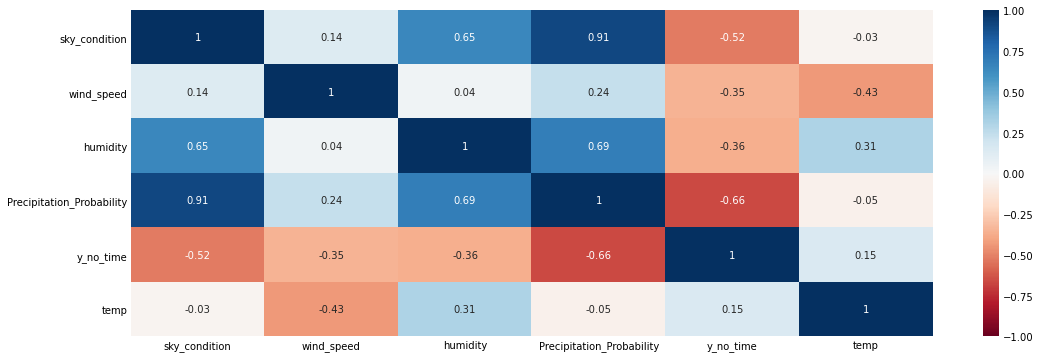

In [83]:
corr2 = np.round(bicycle_new.corr(),2)
mask = np.triu(np.ones_like(corr2, dtype=np.bool))
plt.figure(figsize=(16,6))
hm = sns.heatmap(corr2,
                 #mask=mask,
                 vmin=-1, 
                 vmax=1, 
                 annot=True,
                 cmap='RdBu'
    )

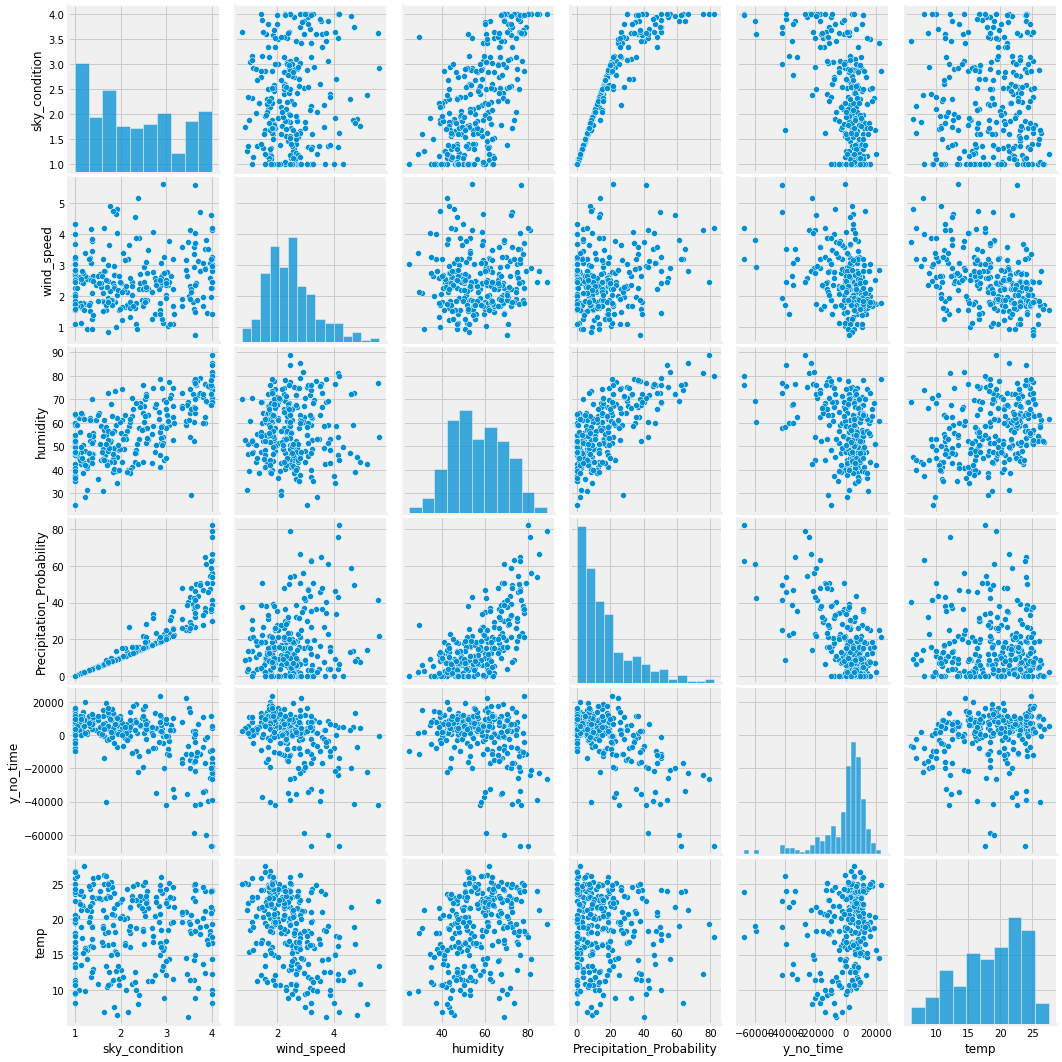

In [84]:
sns.pairplot(bicycle_new)

In [85]:
desc = bicycle_new.describe()

In [86]:
desc

,sky_condition,wind_speed,humidity,Precipitation_Probability,y_no_time,temp
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,2.288256,2.480963,56.745491,16.878103,-25.817035,18.589991
std,0.961775,0.884397,12.351268,16.643772,14540.483065,5.052679
min,1.000000,0.753000,24.831000,0.000000,-66885.009831,6.197500
25%,1.405000,1.820000,47.196000,4.054000,-2975.857794,15.083500
50%,2.167000,2.411000,55.845000,12.162000,4054.958796,19.398000
75%,3.000000,2.924000,66.419000,22.973000,8079.028538,22.837500
max,4.000000,5.607000,88.885000,82.162000,23659.309092,27.523000


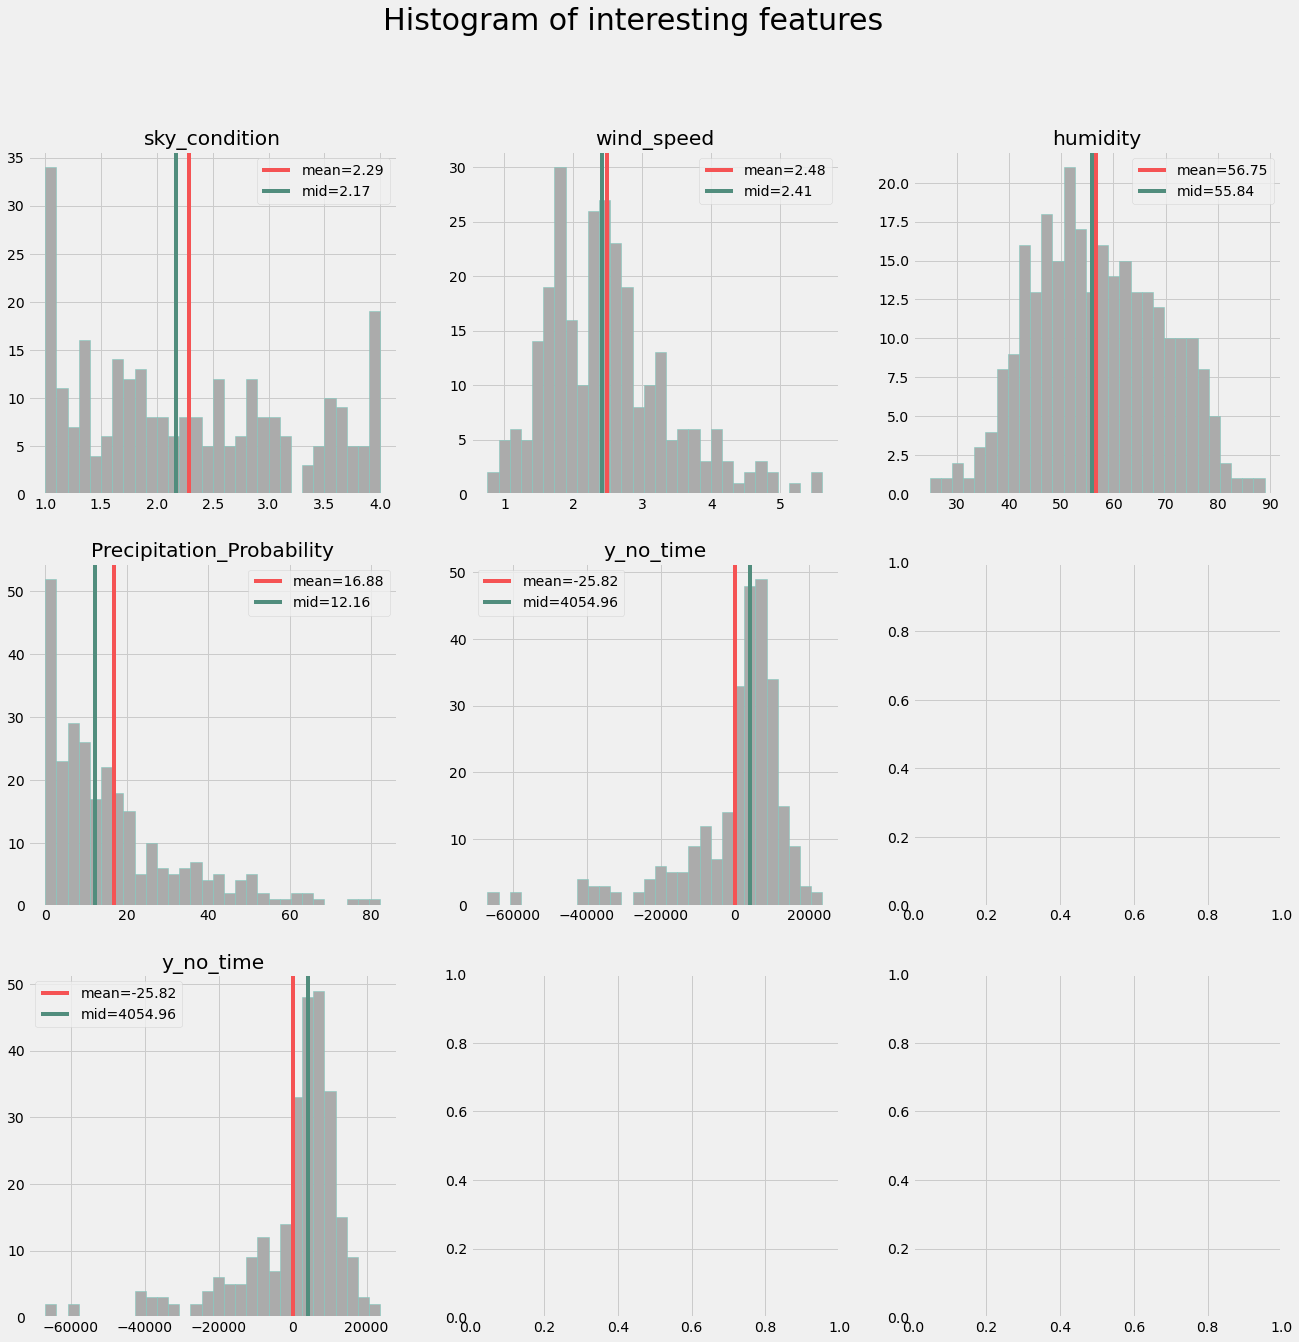

In [87]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(3, 3, figsize=(20,20))

fig.suptitle('Histogram of interesting features', fontsize=30)

col_i = 0
for i in range(3):
    for j in range(3):
        col_name = bicycle_new.columns[col_i]
        mean = desc[col_name]['mean']
        mid = desc[col_name]['50%']
        ax[i][j].hist(bicycle_new[col_name], 
                      bins=30, 
                      color='#ababab',
                      edgecolor='#7bcabf')
        ax[i][j].set_title(bicycle_new.columns[col_i])
        ax[i][j].axvline(mean,
                         c='#f55354',
                         label=f'mean={round(mean,2)}'
                        )
        ax[i][j].axvline(mid,
                         c='#518d7d',
                         label=f'mid={round(mid,2)}'
                        )
        ax[i][j].legend()
        
        if col_i == 4:
            break
        col_i += 1

## 3. Model

In [88]:
X = bicycle_new.drop('y_no_time', axis=1)
y = bicycle_new['y_no_time']

### Scale

In [89]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

In [90]:
# for scaler in [StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer] :
#     scaled_X = pd.DataFrame(scaler().fit_transform(X))
#     sns.pairplot(scaled_X)

In [91]:
scaler = PowerTransformer()
scaled_X = scaler.fit_transform(X)

In [92]:
t_bicycle_new.columns

Index(['sky_condition', 'wind_speed', 'humidity', 'Precipitation_Probability',
       'temp'],
      dtype='object')

In [93]:
X.columns

Index(['sky_condition', 'wind_speed', 'humidity', 'Precipitation_Probability',
       'temp'],
      dtype='object')

In [94]:
t_scaled_X = scaler.transform(t_bicycle_new)

### Fit

In [95]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(scaled_X, y)

LinearRegression()

### Predict

In [96]:
def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

In [97]:
y_hat = model.predict(scaled_X)

nmae = NMAE(y, y_hat)

print(f'모델 NMAE : {nmae}')

모델 NMAE : 0.5894699428581647


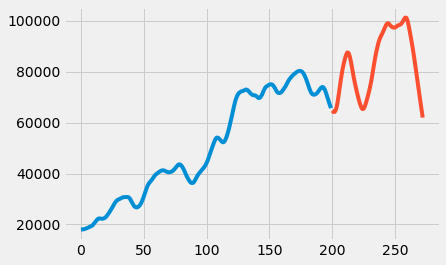

In [98]:
#from statsmodels.tsa.arima.model import ARIMA
#from statsmodels import tsa
from pmdarima import auto_arima

#stlf = tsa.forecasting.stl.STLForecast(nor, model = stl, model_kwargs=dict(order=(1,1,0), trend='t'))
arima_train = res.trend[:200]
arima_test = res.trend[200:]
plt.plot(train)
plt.plot(test)

In [112]:
arima_model = auto_arima(res.trend, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, 
                        start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, m=12, seasonal=False,
                        trace=True, stepwise=True, random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4224.036, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3224.799, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4261.838, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2813.371, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2815.293, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2815.315, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3022.766, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2816.777, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2812.728, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3226.082, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2814.535, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2814.590, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3022.895, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : 

### CV

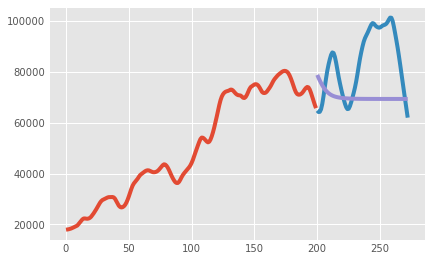

In [114]:
plt.plot(train)
plt.plot(test)
plt.plot(pd.DataFrame(arima_model.predict(73),index=test.index))

arima_predict = arima_model.predict(submission.shape[0])

In [101]:
##### from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit

#for i in range(2,10):
    
n_split = 5

tscv = TimeSeriesSplit(n_splits=n_split)

scores = []

model = LinearRegression()

for train_index, test_index in tscv.split(scaled_X, y):
    train_X = scaled_X[train_index]
    test_X = scaled_X[test_index]
    train_y = y[train_index]
    test_y = y[test_index]

    model.fit(train_X, train_y)

    y_pred = model.predict(test_X)

    scores.append(NMAE(test_y, y_pred))

#print(i, 
np.mean(scores)
#     )

model.fit(scaled_X, y)
y_hat = model.predict(scaled_X)
nmae = NMAE(y, y_hat)
print(f'모델 NMAE : {nmae}')

모델 NMAE : 0.5894699428581647


## 4.Evaluate Model

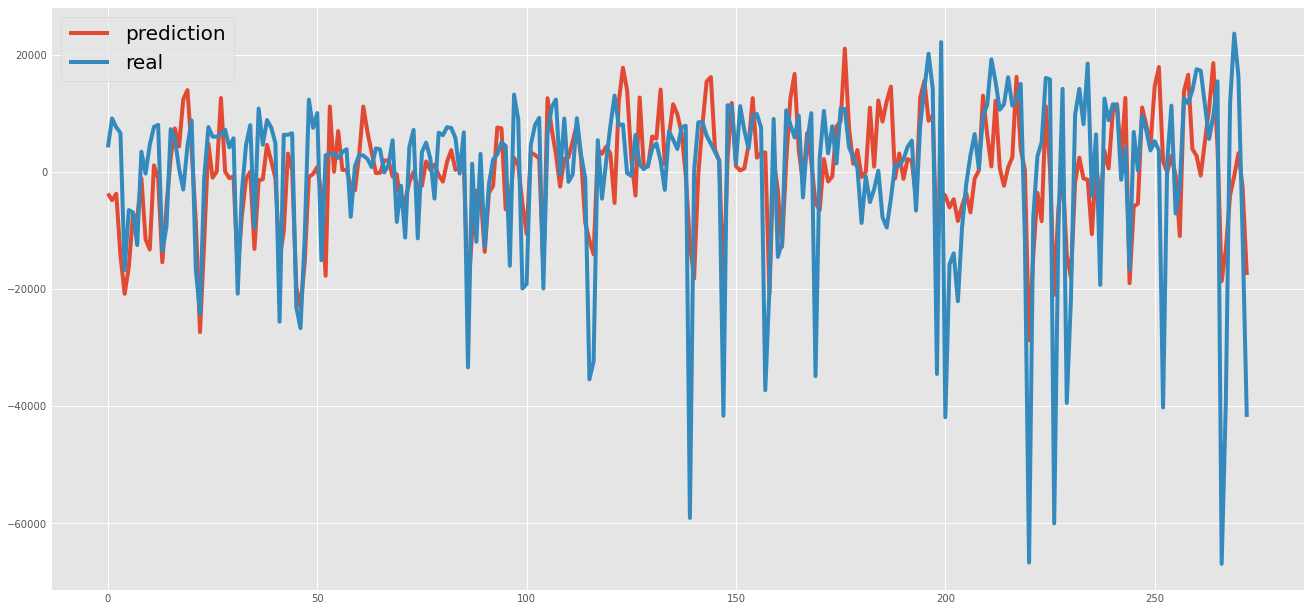

In [115]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(y_hat, label='prediction')
plt.plot(y, label='real')
plt.legend(fontsize=20)
plt.show()

## 5.Submission

In [116]:
submission = pd.read_csv('_data/sample_submission.csv')

In [117]:
result = model.predict(t_scaled_X)

In [118]:
submission['number_of_rentals'] = result + arima_predict

In [131]:
#submission.to_csv('_result/3.time_series.csv', index=False)